# Amplitude damping channel

In [88]:
from sympy import I, sqrt, symbols, exp, cos, sin, Symbol, Add, Matrix, sqrt, pi
from sympy.physics.quantum import TensorProduct as ox

theta, psi = symbols(r"\theta, \phi", real=True)
p = Symbol(r"p", positive=True, real=True)

dpsi = Matrix([0, cos(theta), exp(I * psi) * sin(theta), 0])

M_0 = Matrix([[1, 0], [0, sqrt(1-p)]])
M_1 = Matrix([[0, sqrt(p)], [0, 0]])

rho_ab = Add(*[ox(m_u, m_v) * (dpsi * dpsi.H) * ox(m_u.H, m_v.H) for m_u in [M_0, M_1] for m_v in [M_0, M_1]])

rho_ab

Matrix([
[p*sin(\theta)**2 + p*cos(\theta)**2,                                                                      0,                                                                       0, 0],
[                                  0,                      sqrt(1 - p)*cos(\theta)**2*conjugate(sqrt(1 - p)), sqrt(1 - p)*exp(-I*\phi)*sin(\theta)*cos(\theta)*conjugate(sqrt(1 - p)), 0],
[                                  0, sqrt(1 - p)*exp(I*\phi)*sin(\theta)*cos(\theta)*conjugate(sqrt(1 - p)),                       sqrt(1 - p)*sin(\theta)**2*conjugate(sqrt(1 - p)), 0],
[                                  0,                                                                      0,                                                                       0, 0]])

In [89]:
# probabilities

h = Matrix([1, 0]).T
v = Matrix([0, 1]).T
d = (h + v) / sqrt(2)
a = (h - v) / sqrt(2)
r = (h + I * v) / sqrt(2)
l = (h - I * v) / sqrt(2)

m = ox(h, d)
(rho_ab * m.H * m).trace().subs({p: 0.5, theta: 2 * pi  / 5 }).evalf()

0.273872875703132

In [28]:
f_psi = (ox(M_0, M_0) + ox(M_1, M_1)) * (dpsi * dpsi.H)

f_psi

Matrix([
[0,                                               0,                                                0, 0],
[0,                      sqrt(1 - p)*cos(\theta)**2, sqrt(1 - p)*exp(-I*\phi)*sin(\theta)*cos(\theta), 0],
[0, sqrt(1 - p)*exp(I*\phi)*sin(\theta)*cos(\theta),                       sqrt(1 - p)*sin(\theta)**2, 0],
[0,                                               0,                                                0, 0]])

In [5]:
def baseTrace(m: Matrix, base: int) -> Matrix:
    if not m.is_square:
        raise Exception("Matrix should be square")
    
    s = int(m.shape[0] / (2 / 2**base))
    d = int(m.shape[0] / 2) - base
    return Matrix([[m[i, j] + m[i + d, j + d] for i in range(0, s, base + 1)] for j in range(0, s, base + 1)])

baseTrace(rho_ab, 0).subs(sqrt(1- p).conjugate(), sqrt(1 - p))

Matrix([
[p*sin(\theta)**2 + p*cos(\theta)**2 + (1 - p)*sin(\theta)**2,                      0],
[                                                           0, (1 - p)*cos(\theta)**2]])

# Experiment

In [3]:
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler as PrimitiveSampler
from qiskit.circuit import Clbit, ClassicalRegister, Parameter
from qiskit_aer import AerProvider
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import DensityMatrix, partial_trace, concurrence
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Sampler
from qiskit.visualization import array_to_latex, plot_state_city
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from math import pi, asin, sqrt, acos

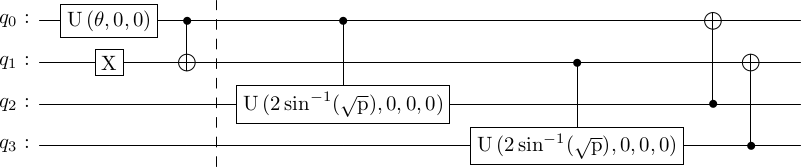

In [15]:
t = Parameter(r'\theta')
p = Parameter(r'2\sin^{-1}(\sqrt{p})')

qc = QuantumCircuit(4)
qc.u(t, 0, 0, 0)
qc.x(1)
qc.cx(0, 1)

qc.barrier()

qc.cu(p, 0, 0, 0, 0, 2)
qc.cx(2, 0)

qc.cu(p, 0, 0, 0, 1, 3)
qc.cx(3, 1)
qc.draw("latex")

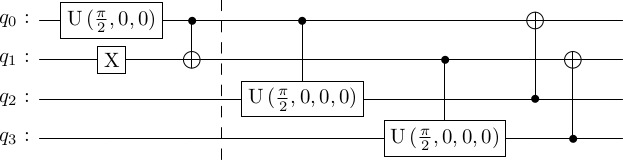

In [4]:
def build_circuit(t: int, p: int, v=0) -> QuantumCircuit:
	if v == 0:
		qc = QuantumCircuit(4)
		qc.u(t, 0, 0, 0)
		qc.x(1)
		qc.cx(0, 1)

		qc.barrier()

		theta = 2 * asin(sqrt(p))
		qc.cu(theta, 0, 0, 0, 0, 2)
		qc.cx(2, 0)

		qc.cu(theta, 0, 0, 0, 1, 3)
		qc.cx(3, 1)
		return qc
	elif v == 1:
		qc = QuantumCircuit(3)
		theta = 2 * acos(sqrt(p))
		qc.u(theta, 0, 0, 2)
		qc.cu(t, 0, 0, 0, 2, 0)
		qc.cx(2, 1)
		qc.cx(0, 1)
		return qc
	else:
		raise Exception("Undefined circuit version")

qc = build_circuit(pi/2, 0.5, v=0)
qc.draw("latex")

In [117]:
qc = build_circuit(pi/5, 0.5, v=0)
dm = DensityMatrix(qc)
dm = partial_trace(dm, (2,3))
array_to_latex(dm.data)

<IPython.core.display.Latex object>

In [17]:
qc = build_circuit(pi / 5, 0.5, v=0)
backend = AerProvider().get_backend("aer_simulator")
st = StateTomography(qc.reverse_bits(), measurement_indices=(0,1))
stdata = st.run(backend, shots=10000).block_for_results()
state_result = stdata.analysis_results("state")
array_to_latex(state_result.value)
# plot_state_city(state_result.value)

<IPython.core.display.Latex object>

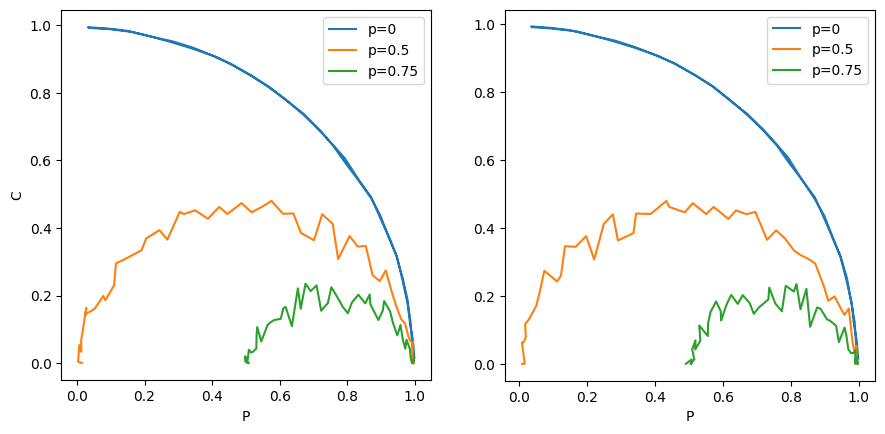

In [24]:
def polarization(density_matrix: DensityMatrix) -> int:
	s1 = 2 * density_matrix.data[0, 0].real - 1
	s2 = 2 * density_matrix.data[0, 1].real
	s3 = - 2 * density_matrix.data[0, 1].imag
	return LA.norm([s1, s2, s3])

backend = AerProvider().get_backend("aer_simulator")
fig, axes = plt.subplots(1, 2)
# ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = axes
(ax1, ax2) = axes
i = 0
angles = np.linspace(0, pi, 50)
for p in [0, 0.5, 0.75]:
	pol0_values = []
	con0_values = []
	pol1_values = []
	con1_values = []
	for t in angles:
		qc = build_circuit(t, p, v=0)

		st = StateTomography(qc, measurement_indices=(0,1))
		stdata = st.run(backend, shots=10000).block_for_results()
		state_result = stdata.analysis_results("state")
		dm0 = partial_trace(state_result.value, (1,))
		dm1 = partial_trace(state_result.value, (0,))
		pol0 = polarization(dm0)
		pol1 = polarization(dm1)
		pol0_values.append(pol0)
		con0_values.append(concurrence(state_result.value))
		pol1_values.append(pol1)
		con1_values.append(concurrence(state_result.value))

	# C and P
	ax1.plot(pol0_values, con0_values, label=f"p={p}")
	ax2.plot(pol1_values, con1_values, label=f"p={p}")
	# # C vs angle
	# ax3.plot(angles, con0_values, label=f"p={p}")
	# ax4.plot(angles, con1_values, label=f"p={p}")
	# # P vs angle
	# ax5.plot(angles, pol0_values, label=f"p={p}")
	# ax6.plot(angles, pol1_values, label=f"p={p}")

for a in (ax1, ax2):
	a.set_xlabel("P")
	a.legend()
	a.set_aspect("equal")

# for a in (ax3, ax4, ax5, ax6):
# 	a.set_aspect("equal")
# 	a.set_xlabel("$\\theta$")

ax1.set_ylabel("C")
# ax3.set_ylabel("C")
# ax5.set_ylabel("P")

# for a in [j for i in axes for j in i]:
	# a.set_aspect("equal")
# 	a.legend()

fig.set_size_inches(10.5, 7.5)
plt.show()

In [6]:
from typing import Union

def measure_qbit(qc: QuantumCircuit, meas: Union[1, 2, 3], qbit_index: int) -> QuantumCircuit:
	if meas == 2:
		qc.sdg(qbit_index)
		qc.h(qbit_index)
	elif meas == 1:
		qc.h(qbit_index)

	qc.measure(qbit_index, qbit_index)

In [ ]:
from quantum.common.qiskit_run import ParametricExperiment

p = 0.5
t = pi
qc = build_circuit(t, p)
cl_reg = ClassicalRegister(name="c", bits=[Clbit(), Clbit()])
qc.add_register(cl_reg)

service = QiskitRuntimeService()
experiment = ParametricExperiment("./quantum/data/amplitude_damping.json", t, p)
with Session(service=service, backend="ibm_nairobi") as session:
	jobs = []
	for i in [1, 2, 3]:
		for j in [1, 2, 3]:
			print(f"Running for S({i}, {j})")
			_qc = qc.copy()
			_qc.name = f"measurement S({i}, {j})"
			measure_qbit(_qc, i, 0)
			measure_qbit(_qc, j, 1)

			job = Sampler().run(_qc)
			jobs.append(job)
			print(job.job_id())
			experiment.add_job({
				"s": [i, j],
				"id": job.job_id(),
			})

	for j in jobs:
		print(j.result().quasi_dists[0])
		print(f"Finished job {j.job_id()}")

	session.close()

[{0: 0.323473156536559, 1: 0.1765268434634408, 2: 0.1765268434634408, 3: 0.323473156536559}]


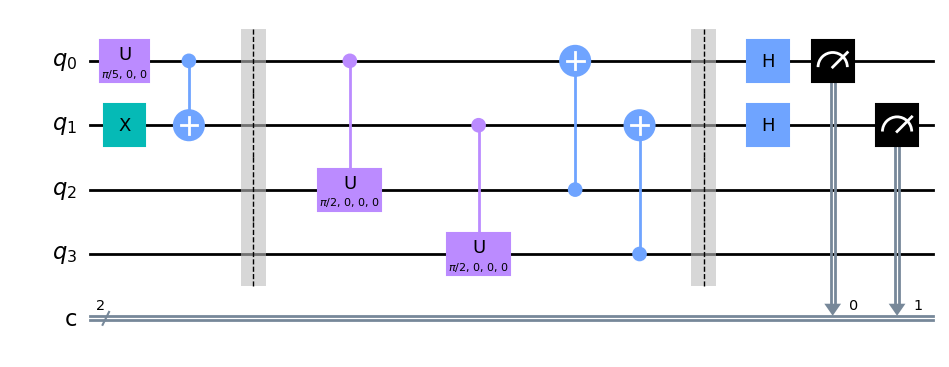

In [10]:
qc = build_circuit(pi / 5, 0.5)
cl_reg = ClassicalRegister(name="c", bits=[Clbit(), Clbit()])
qc.add_register(cl_reg)
qc.barrier()
measure_qbit(qc, 1, 0)
measure_qbit(qc, 1, 1)
job = PrimitiveSampler().run(qc)
print(job.result().quasi_dists)
qc.draw("mpl")

In [79]:
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

estimator = Estimator()
qc = build_circuit(pi / 5, 0.5)
observable = SparsePauliOp("ZZII")
job = estimator.run(qc, observable)
result = job.result()
result.values[0]

-1.6653345369377348e-16